<a href="https://colab.research.google.com/github/elichen/oai-playground/blob/main/Processing_and_narrating_a_video_with_GPT's_visual_capabilities_and_the_TTS_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%pip install --upgrade openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00


In [8]:
from google.colab import userdata
from openai import OpenAI
client = OpenAI(api_key=userdata.get('openai-key'))

In [9]:
import json
import pandas as pd
from IPython.display import Image, display

In [2]:
import requests
DATASET_URL = "https://github.com/openai/openai-cookbook/raw/main/examples/data/bison.mp4"
response = requests.get(DATASET_URL)
DATASET_PATH = "bison.mp4"
with open(DATASET_PATH, 'wb') as file:
    file.write(response.content)

In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
import os
import requests

In [3]:
video = cv2.VideoCapture("bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


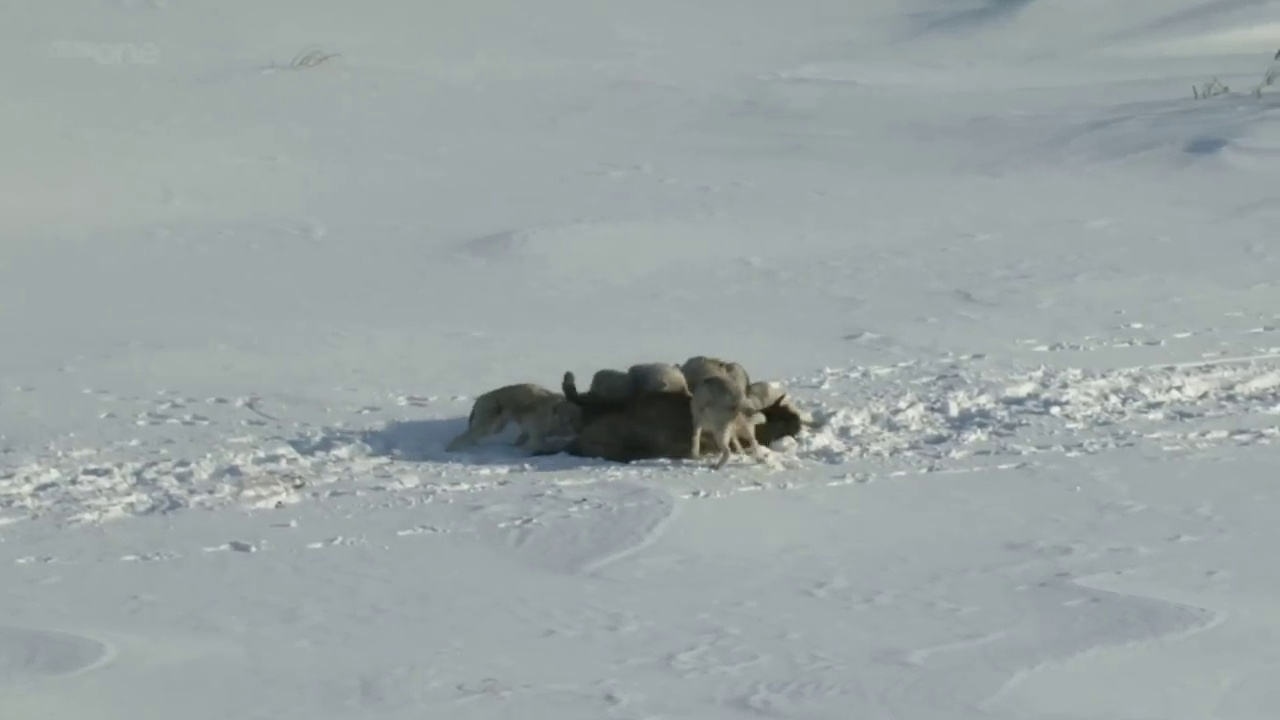

In [4]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [10]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Witness the wild in action as a pack of wolves orchestrates a coordinated hunt amidst the snowy plains! Watch as every bite, howl, and sprint culminates in a breathtaking display of nature's untamed power. This dramatic footage captures the relentless spirit of survival, showcasing the wolves' strategic prowess and the awe-inspiring battle between predator and prey. A true testament to the raw and unforgiving beauty of the animal kingdom. Don't miss this exhilarating moment that brings the wilderness to your screen. 🌲❄️🐺 #Wildlife #Nature #Wolves #Predator #Survival #NaturalWorld


In [11]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

In the vast, unyielding expanse of the Arctic's wintry wilderness, a delicate balance of life hangs by a thread. 

Here, among the snow-laden plains, a pack of wolves has set their sights on a formidable prize—the majestic bison.

Relentless and coordinated, the wolves encircle their quarry, each movement a testament to their age-old, finely tuned hunting prowess.

A bison, towering yet vulnerable in its solitary state, fights back with sheer might, attempting to shake off its determined attackers. But the wolves, driven by hunger and survival, hold steadfast, relentlessly pressing their attack.

A second bison joins the fray, a defensive maneuver in a desperate bid to protect its kin. Yet, the pack’s unity and strategic prowess steer the battle to a dire conclusion.

In this brutal ballet of predator and prey, the circle of life continues to turn. The pack's persistence pays off, securing a lifeline of sustenance in the harsh, frozen landscape.

As the wolves feast, the silence of the

In [13]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {userdata.get('openai-key')}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)